In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

2025-04-08 08:57:13.625289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
try:
    layer = tf.keras.layers.LSTM(units=50, return_sequences=True)
    print("tf.keras.models!")
except AttributeError as e:
    print(f"Error: {e}")

tf.keras.models!


In [4]:
price_gold = pd.read_csv('../data/processed-data/price-gold.csv', index_col='Date')
print(price_gold.head())

lookback_period = 10
test_size = 0.2

data = price_gold[['Open', 'Close', 'High', 'Low', 'Vol.']].copy()
data = data.dropna()  # Handle potential missing values
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
print(scaled_data)
# Save the scaler after fitting
import joblib
joblib.dump(scaler, 'scaler.save')


             Close    Open    High     Low      Vol. Change %
Date                                                         
2015-01-02  1186.2  1184.0  1194.9  1167.3  120680.0    0.18%
2015-01-05  1204.0  1187.8  1207.5  1177.8  149110.0    1.50%
2015-01-06  1219.4  1204.0  1223.3  1201.6  190360.0    1.28%
2015-01-07  1210.7  1219.0  1219.4  1209.1  117090.0   -0.71%
2015-01-08  1208.5  1211.0  1216.8  1204.2  122490.0   -0.18%
[[0.12764933 0.13212109 0.12263451 0.11844151 0.1476709 ]
 [0.13131021 0.14933746 0.13432282 0.12864361 0.18249409]
 [0.14691715 0.16423252 0.14897959 0.15176836 0.23302017]
 ...
 [0.94845857 0.94612632 0.91233766 0.95268169 0.25096459]
 [0.94210019 0.9378083  0.92152134 0.94432569 0.36895677]
 [0.94576108 0.96914595 0.93191095 0.95967742 0.33344765]]


['scaler.save']

In [ ]:
def create_sequences(data, lookback):
        X, y = [], []
        for i in range(lookback, len(data)-6):
            X.append(data[i - lookback:i])
            y.append(data[i:i+6, 1])  # Predict the 'Close' price (index 1)
        return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, lookback_period)

# Split into training and testing sets
train_size = int(len(X) * (1 - test_size))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

InvalidIndexError: (slice(10, 16, None), 1)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dense(units=6))  # Output layer to predict the next 'Close' price

# 3. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/home/elm19/miniconda3/envs/goldspot-predictor/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,706 (123.85 KB)

 Trainable params: 31,706 (123.85 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# 4. Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 9.1091e-04
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 9.7704e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.1512e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.3626e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.3280e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.9407e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.2965e-04
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.6592e-04
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.4462e-04
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.3770e-04
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.3716e-04
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.5628e-04
Epoch 13/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.4557e-04
Epoch 14/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 7.9339e-04
Epoch 15/50
58/58 ━━━━━━━━

In [20]:
model.save('../models/model1/lstm_model.keras')

In [14]:
model.evaluate(X_test, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016


0.001337274443358183

In [15]:
predicted_scaled = model.predict(X_test)

# Inverse transform the predictions
predicted_prices = np.zeros((predicted_scaled.shape[0], predicted_scaled.shape[1]))
for i in range(predicted_scaled.shape[1]):
    dummy_predictions = np.zeros((len(predicted_scaled), 5))
    dummy_predictions[:, 1] = predicted_scaled[:, i]
    predicted_prices[:, i] = scaler.inverse_transform(dummy_predictions)[:, 1]

# Get the actual 'Close' prices from the test set
test_start_index = int(len(data) * (1 - test_size))+lookback_period
actual_close_test = data['Close'].iloc[test_start_index:]
num_test_samples = predicted_prices.shape[0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


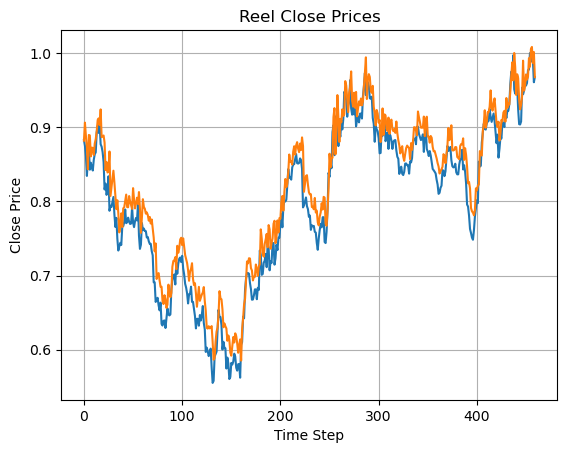

In [16]:
reel_prices = [y_test[i, 0] for i in range(y_test.shape[0])]
reel_prices = np.array(reel_prices)
plt.plot(reel_prices)
plt.plot([predicted_scaled[i, 0] for i in range(len(predicted_scaled)) ])
plt.title('Reel Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.grid(True)

plt.show()